In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
import pylab as py
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))


In [14]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [15]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
print y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

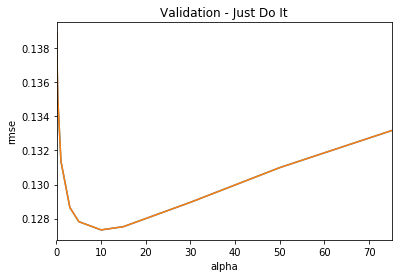

In [18]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [17]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

rmse_cv(model_lasso).mean()

coef = pd.Series(model_lasso.coef_, index = X_train.columns)


preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)


In [19]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
t = all_data[numeric_feats].quantile(.75)

In [20]:
t

MSSubClass                  4.262680
LotFrontage                 4.369448
LotArea                     9.356257
OverallQual                 7.000000
OverallCond                 6.000000
YearBuilt                2001.000000
YearRemodAdd             2004.000000
MasVnrArea                  5.102906
BsmtFinSF1                  6.598509
BsmtFinSF2                  0.000000
BsmtUnfSF                   6.692083
TotalBsmtSF                 7.172425
1stFlrSF                    7.235979
2ndFlrSF                    6.558198
LowQualFinSF                0.000000
GrLivArea                   7.464223
BsmtFullBath                1.000000
BsmtHalfBath                0.000000
FullBath                    2.000000
HalfBath                    1.000000
BedroomAbvGr                3.000000
KitchenAbvGr                0.693147
TotRmsAbvGrd                7.000000
Fireplaces                  1.000000
GarageYrBlt              2001.000000
GarageCars                  2.000000
GarageArea                576.000000
W